In [58]:
import pandas as pd
import numpy as np

customer_df = pd.read_csv('../data/customerChurn/customer_churn_dataset-training-master.csv')
customer_test_df = pd.read_csv('../data/customerChurn/customer_churn_dataset-testing-master.csv')

In [59]:
customer_df.head(5)

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


In [60]:
customer_df.drop('CustomerID', inplace=True, axis=1)

In [61]:
customer_df.head(5)

,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


In [62]:
customer_df.dropna(subset=['Churn'], inplace=True)
print(customer_df['Churn'].isna().sum())
customer_df['Churn'].value_counts()

0


Churn
1.0    249999
0.0    190833
Name: count, dtype: int64

In [63]:
categorical_cols = customer_df.select_dtypes(include='object').columns.to_list()
numerical_cols = customer_df.select_dtypes(include=np.number).columns.to_list()[:-1]
numerical_cols


['Age',
 'Tenure',
 'Usage Frequency',
 'Support Calls',
 'Payment Delay',
 'Total Spend',
 'Last Interaction']

In [64]:
for col in categorical_cols:
    print(customer_df[col].value_counts())

Gender
Male      250252
Female    190580
Name: count, dtype: int64
Subscription Type
Standard    149128
Premium     148678
Basic       143026
Name: count, dtype: int64
Contract Length
Annual       177198
Quarterly    176530
Monthly       87104
Name: count, dtype: int64


In [65]:
X_cols, y_cols = customer_df.columns[0:-1], customer_df.columns[-1]
X_cols, y_cols

(Index(['Age', 'Gender', 'Tenure', 'Usage Frequency', 'Support Calls',
        'Payment Delay', 'Subscription Type', 'Contract Length', 'Total Spend',
        'Last Interaction'],
       dtype='object'),
 'Churn')

In [66]:
X, y = customer_df[X_cols], customer_df[y_cols]

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


In [68]:
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])
model.fit(X_train, y_train)


,steps,"[('preprocess', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [70]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

0.8949111531190926

In [71]:
baseline = y_test.value_counts(normalize=True).max()
print(f"Baseline (Majority Class %): {baseline:.2f}")

Baseline (Majority Class %): 0.57


In [26]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

# 1. Define the dictionary of models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# 2. Loop through and evaluate
results = []

for name, classifier in models.items():
    clf_pipeline = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("classifier", classifier)
    ])
    
    scores = cross_val_score(clf_pipeline, X, y, cv=5, scoring="accuracy")
    
    print(f"{name}: Mean CV Accuracy = {scores.mean():.4f}")


Logistic Regression: Mean CV Accuracy = 0.8954
Random Forest: Mean CV Accuracy = 0.9992


d:\python projects\MachineLearning - Copy\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [13:44:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\python projects\MachineLearning - Copy\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [13:44:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\python projects\MachineLearning - Copy\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [13:44:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\python projects\MachineLearning - Copy\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [13:44:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\

XGBoost: Mean CV Accuracy = 0.9999


In [73]:
X_train.columns

Index(['Age', 'Gender', 'Tenure', 'Usage Frequency', 'Support Calls',
       'Payment Delay', 'Subscription Type', 'Contract Length', 'Total Spend',
       'Last Interaction'],
      dtype='object')

In [76]:
for col in X[numerical_cols].columns:
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train[[col]], y_train)
    acc = accuracy_score(y_test, clf.predict(X_test[[col]]))
    print(col, acc)


Age 0.6478185255198488
Tenure 0.5691190926275993
Usage Frequency 0.5691190926275993
Support Calls 0.7676672967863895
Payment Delay 0.6233648393194707


KeyboardInterrupt: 

### MONOTONIC OPTIMAL BINNING

In [53]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

encoder.fit(customer_df[categorical_cols])
encoded_cols = encoder.get_feature_names_out()
customer_df[encoded_cols] = encoder.transform(customer_df[categorical_cols])

In [54]:
final_cols = list(dict.fromkeys(list(encoded_cols) + numerical_cols))

In [56]:
customer_df[final_cols + ['Churn']].corr()['Churn']

Gender_Female                 0.175395
Gender_Male                  -0.175395
Subscription Type_Basic       0.020526
Subscription Type_Premium    -0.011072
Subscription Type_Standard   -0.009247
Contract Length_Annual       -0.175965
Contract Length_Monthly       0.433553
Contract Length_Quarterly    -0.176244
Age                           0.218394
Tenure                       -0.051919
Usage Frequency              -0.046101
Support Calls                 0.574267
Payment Delay                 0.312129
Total Spend                  -0.429355
Last Interaction              0.149616
Churn                         1.000000
Name: Churn, dtype: float64

In [64]:
target='Churn'
x_cols = final_cols[0:-1]
final_cols

['Gender_Female',
 'Gender_Male',
 'Gender_nan',
 'Subscription Type_Basic',
 'Subscription Type_Premium',
 'Subscription Type_Standard',
 'Subscription Type_nan',
 'Contract Length_Annual',
 'Contract Length_Monthly',
 'Contract Length_Quarterly',
 'Contract Length_nan',
 'Age',
 'Tenure',
 'Usage Frequency',
 'Support Calls',
 'Payment Delay',
 'Total Spend',
 'Last Interaction',
 'Churn']

### BINNING TO GET THE FEATURE IMPORTANCE

In [66]:
from optbinning import OptimalBinning

binning_results = {}
for feature in [col for col in final_cols if col != target]:
    optb = OptimalBinning(name=feature, dtype="numerical", monotonic_trend="auto",max_n_bins=12)
    optb.fit(customer_df[feature].values, customer_df[target].values)
    binning_results[feature] = optb

    customer_df[f"{feature}_woe"] = optb.transform(customer_df[feature].values, metric="woe")

if 'Age' in binning_results:
    print("\n--- Binning Table for Age ---")
    print(binning_results['Age'].binning_table.build())


--- Binning Table for Age ---
                   Bin   Count  Count (%)  Non-event   Event  Event rate  \
0        (-inf, 20.50)   25845   0.058628      10196   15649    0.605494   
1       [20.50, 24.50)   38191   0.086634      17455   20736    0.542955   
2       [24.50, 29.50)   47990   0.108862      22182   25808    0.537779   
3       [29.50, 39.50)  109962   0.249441      58818   51144    0.465106   
4       [39.50, 42.50)   37309   0.084633      22351   14958    0.400922   
5       [42.50, 48.50)   74023   0.167916      43764   30259    0.408778   
6         [48.50, inf)  107512   0.243884      16067   91445    0.850556   
7              Special       0   0.000000          0       0    0.000000   
8              Missing       1   0.000002          0       1    0.000000   
Totals                  440833   1.000000     190833  250000    0.567108   

             WoE        IV        JS  
0      -0.158349  0.001452  0.000181  
1       0.097817  0.000834  0.000104  
2       0.11865

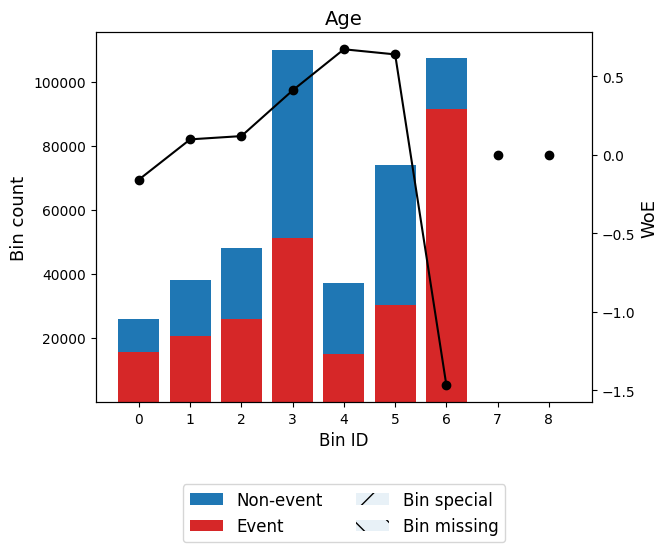

In [67]:
import matplotlib.pyplot as plt

# Visualize the trend for 'Age'
if 'Age' in binning_results:
    # This generates a plot showing Event Rate and WoE per bin
    binning_results['Age'].binning_table.plot(metric="woe")

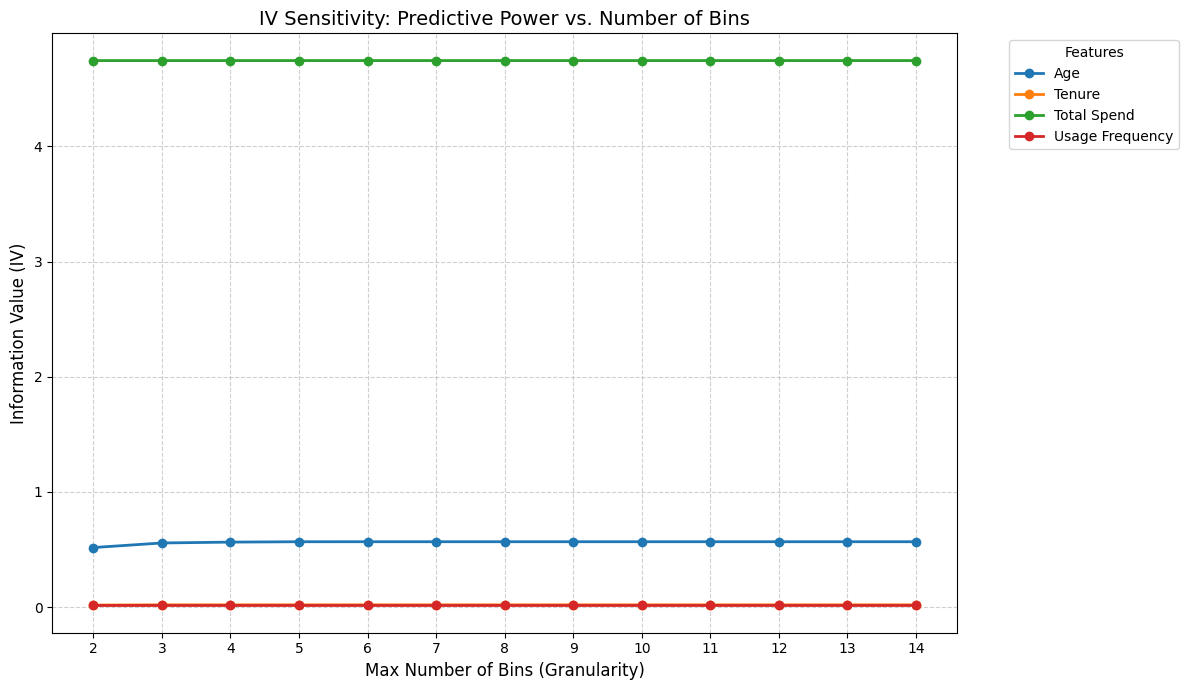

In [71]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Configuration
bin_range = range(2, 15)  # Testing from 2 to 14 bins
target = 'Churn'
# Focus on your main numerical features
features_to_plot = ['Age', 'Tenure', 'Total Spend', 'Usage Frequency'] 

results = []

# 2. Loop through different bin counts
for n in bin_range:
    for feature in features_to_plot:
        try:
            optb = OptimalBinning(name=feature, dtype="numerical", 
                                  monotonic_trend="auto", 
                                  max_n_bins=n)
            optb.fit(customer_df[feature].values, customer_df[target].values)
            
            # Extract IV from the Totals row
            table_df = optb.binning_table.build()
            iv = table_df.loc[table_df.index == 'Totals', 'IV'].values[0]
            
            results.append({'Feature': feature, 'MaxBins': n, 'IV': float(iv)})
        except:
            continue

# 3. Create a plotting DataFrame
df_res = pd.DataFrame(results)

# 4. Plotting the Line Chart
plt.figure(figsize=(12, 7))
for feature in features_to_plot:
    data = df_res[df_res['Feature'] == feature]
    plt.plot(data['MaxBins'], data['IV'], marker='o', label=feature, linewidth=2)

plt.title('IV Sensitivity: Predictive Power vs. Number of Bins', fontsize=14)
plt.xlabel('Max Number of Bins (Granularity)', fontsize=12)
plt.ylabel('Information Value (IV)', fontsize=12)
plt.xticks(bin_range)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Features", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()